In [7]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import random 
import os 
import pandas as pd 

from work import handler
from work import casestudy
from work import storm_tracker

from work.plots.hist import simple_hist

settings_path = 'settings/sam3d.yaml'

hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 0.20 seconds


In [28]:
duration_min = 6  # or 10
surfmaxkm2_min = 10000  # or other value
region_latmin, region_latmax, region_lonmin, region_lonmax = -15, 30, -180, 180
filename_save = f"profile_dataset_storms_dmin{duration_min}_smin{surfmaxkm2_min}_lat{region_latmin}_{region_latmax}_lon{region_lonmin}_{region_lonmax}.nc"
storms_path = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, filename_save)
ds = xr.open_dataset(storms_path)
ds = ds.drop_isel(DCS_number = [353, 373, 374, 397, 398, 399, 426])
ds

<xarray.Dataset>
Dimensions:                   (DCS_number: 521, z: 52)
Coordinates:
  * DCS_number                (DCS_number) int64 153512 153524 ... 295399 297410
  * z                         (z) float32 20.0 61.2 ... 1.447e+04 1.497e+04
Data variables: (12/14)
    TABS_init_profile         (DCS_number, z) float64 ...
    QV_init_profile           (DCS_number, z) float64 ...
    U_init_profile            (DCS_number, z) float64 ...
    V_init_profile            (DCS_number, z) float64 ...
    TABS_max_instant_profile  (DCS_number, z) float64 ...
    QV_max_instant_profile    (DCS_number, z) float64 ...
    ...                        ...
    lon_init                  (DCS_number) float64 ...
    lat_init                  (DCS_number) float64 ...
    time_init                 (DCS_number) datetime64[ns] ...
    lon_max_instant           (DCS_number) float64 ...
    lat_max_instant           (DCS_number) float64 ...
    time_max_instant          (DCS_number) datetime64[ns] ...

# Data Processing


## Scale for each features*levels individually (works better)

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_profiles_v1(ds, scaler=None):
    # Extract the profile data
    TABS_init_profile = ds['TABS_init_profile'].values
    QV_init_profile = ds['QV_init_profile'].values
    U_init_profile = ds['U_init_profile'].values
    V_init_profile = ds['V_init_profile'].values

    TABS_max_instant_profile = ds['TABS_max_instant_profile'].values
    QV_max_instant_profile = ds['QV_max_instant_profile'].values
    U_max_instant_profile = ds['U_max_instant_profile'].values
    V_max_instant_profile = ds['V_max_instant_profile'].values

    z_levels = ds.z.values
    # Compute wind shear for initial profiles
    delta_U_init = np.diff(U_init_profile, axis=1)/np.diff(z_levels)
    delta_V_init = np.diff(V_init_profile, axis=1)/np.diff(z_levels)
    shear_magnitude_init = np.sqrt(delta_U_init**2 + delta_V_init**2)
    shear_direction_init = np.arctan2(delta_V_init, delta_U_init)  # In radians

    # Compute wind shear for max instant profiles
    delta_U_max = np.diff(U_max_instant_profile, axis=1)/np.diff(z_levels)
    delta_V_max = np.diff(V_max_instant_profile, axis=1)/np.diff(z_levels)
    shear_magnitude_max = np.sqrt(delta_U_max**2 + delta_V_max**2)
    shear_direction_max = np.arctan2(delta_V_max, delta_U_max)  # In radians

    lon1, lat1, lon2, lat2 = map(np.radians, [ds['lon_init'], ds['lat_init'], ds['lon_max_instant'], ds['lat_max_instant']])
    delta_lon = lon2 - lon1
    delta_lat = lat2 - lat1
    direction_propagation = np.arctan2(delta_lat, delta_lon) ## In radians

    # Add padding at the top layer to maintain the original number of levels
    pad_width = ((0, 0), (1, 0))  # Pad before the first vertical level
    shear_magnitude_init = np.pad(shear_magnitude_init, pad_width, mode='constant', constant_values=0)
    shear_direction_init = np.pad(shear_direction_init, pad_width, mode='constant', constant_values=0)
    shear_magnitude_max = np.pad(shear_magnitude_max, pad_width, mode='constant', constant_values=0)
    shear_direction_max = np.pad(shear_direction_max, pad_width, mode='constant', constant_values=0)

    profiles_init_stack = np.stack([
        TABS_init_profile,
        QV_init_profile,
        U_init_profile,
        V_init_profile,
        shear_magnitude_init,
        shear_direction_init
    ], axis=2)

    profiles_max_stack = np.stack([
        TABS_max_instant_profile,
        QV_max_instant_profile,
        U_max_instant_profile, 
        V_max_instant_profile,
        shear_magnitude_max,
        shear_direction_max
    ], axis=2)

    # Concatenate initial and max profiles
    X = np.concatenate([profiles_init_stack, profiles_max_stack], axis=2)
    num_samples, num_levels, num_features = X.shape

    # Reshape to 2D array for scaling
    X_reshaped = X.reshape(-1, num_features)

    # Initialize or use provided scaler
    if scaler is None:
        scaler_profiles = StandardScaler()
        X_scaled_reshaped = scaler_profiles.fit_transform(X_reshaped)
    else:
        scaler_profiles = scaler
        X_scaled_reshaped = scaler_profiles.transform(X_reshaped)

    X_scaled = X_scaled_reshaped.reshape(num_samples, num_levels, num_features)
    return X, X_scaled, scaler_profiles

# Now, use the updated function
X, X_scaled, scaler_profiles = scale_profiles_v1(ds)
num_samples, num_levels, num_features = X.shape

In [16]:
import joblib
path_scaler_save = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, 'scaler_profiles.joblib')
joblib.dump(scaler_profiles, path_scaler_save)

['/homedata/mcarenso/shear/SAM3d_Tropics/scaler_profiles.joblib']

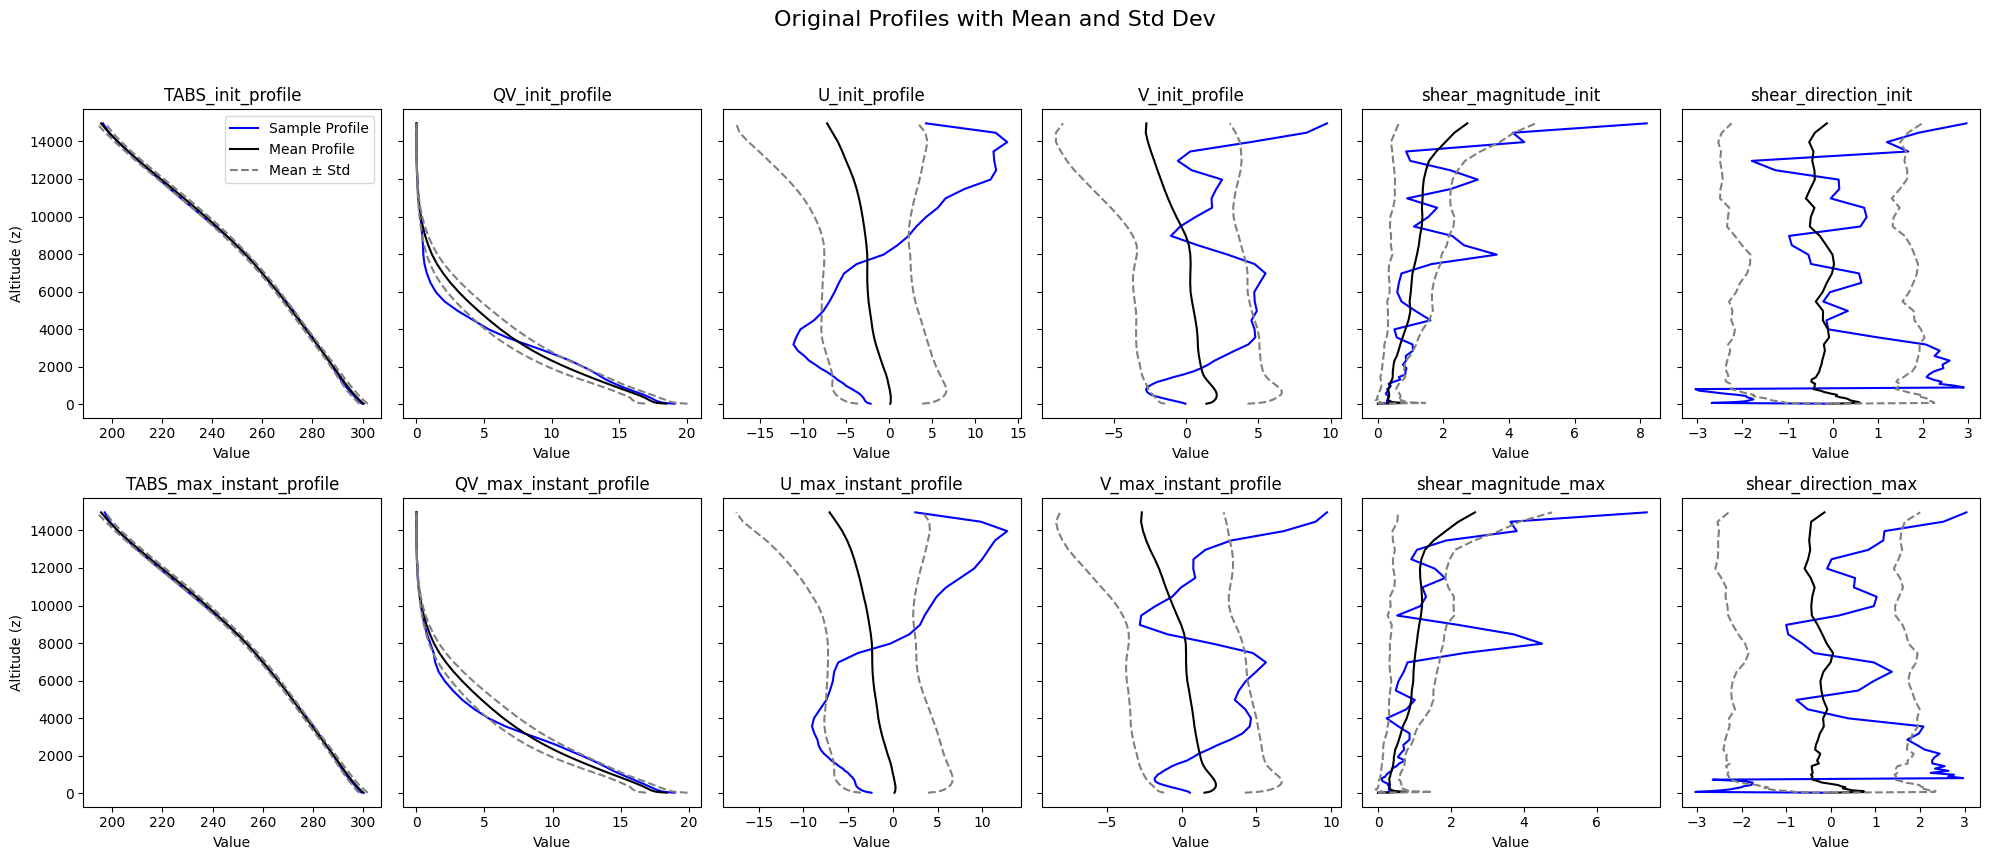

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import circmean, circstd


# Assuming 'ds' and 'X' are already defined in your environment
# 'X' has shape (num_samples, num_levels, num_features)

# Update the variable names to match the new variables
variables = [
    'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile','shear_magnitude_init', 'shear_direction_init',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile', 'shear_magnitude_max', 'shear_direction_max'
]

num_samples, num_levels, num_features = X.shape

# Initialize arrays for mean and std dev profiles
mean_profiles = np.zeros((num_levels, num_features))
std_profiles = np.zeros((num_levels, num_features))

# Compute mean and std dev for each feature at each level over all samples
for i, var in enumerate(variables):
    if var in ['shear_direction_init', 'shear_direction_max']:
        # Use circular statistics for angular data
        mean_profiles[:, i] = np.degrees(circmean(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
        std_profiles[:, i] = np.degrees(circstd(np.radians(X[:, :, i]), high=np.pi, low=-np.pi, axis=0))
    else:
        mean_profiles[:, i] = np.mean(X[:, :, i], axis=0)
        std_profiles[:, i] = np.std(X[:, :, i], axis=0)

# Split data into training and test sets (if needed)
indices = np.arange(num_samples)
X_train, X_test, idx_train, idx_test = train_test_split(
    X, indices, test_size=0.2, random_state=42
)

# Select a random sample from the test set
sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original data for the selected sample
original_sample = X_test[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values  # Vertical levels (assuming shape (num_levels,))

# Prepare to plot
n_cols = 6
fig, axes = plt.subplots(2, n_cols, figsize=(20, 9), sharey=True)
fig.suptitle('Original Profiles with Mean and Std Dev', fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i // n_cols, i % n_cols]

    # Extract the profiles for each variable
    sample_profile = original_sample[:, i]
    mean_profile = mean_profiles[:, i]
    std_profile = std_profiles[:, i]

    # Handle wind shear direction (convert to degrees and wrap angles)
    if var in ['shear_direction_init', 'shear_direction_max']:
        sample_profile = np.degrees(np.arctan2(np.sin(np.radians(sample_profile)), np.cos(np.radians(sample_profile))))
        upper_std = (mean_profile + std_profile + 180) % 360 - 180
        lower_std = (mean_profile - std_profile + 180) % 360 - 180
    else:
        upper_std = mean_profile + std_profile
        lower_std = mean_profile - std_profile

    # Plot sample profile
    ax.plot(sample_profile, z_levels, label='Sample Profile', color='blue')

    # Plot mean profile
    ax.plot(mean_profile, z_levels, color='black', linestyle='-', label='Mean Profile')

    # Plot mean ± std dev profiles
    ax.plot(upper_std, z_levels, color='grey', linestyle='--', label='Mean ± Std' if i == 0 else "")
    ax.plot(lower_std, z_levels, color='grey', linestyle='--')

    ax.set_title(var)
    ax.set_xlabel('Value')

    if i % n_cols == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if altitude increases with decreasing index

    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Model Building #

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

2024-11-29 13:49:28.586654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 13:49:28.607367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 13:49:28.612759: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 13:49:28.628724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-29 13:49:30.121446: W tensorflow/compiler/tf2

## CNNs Conv1D

In [ ]:
latent_space_size = 32
model_name = "ae_conv1D_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)  # Replace num_channels with the number of input channels
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(inputs)
# encoded = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(encoded)
# encoded = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoded)
attention_output = layers.Attention()([encoded, encoded])
flattened = layers.Flatten()(attention_output)
encoded = layers.Dense(64, activation='relu')(flattened)
# encoded = layers.Dense(32, activation='relu')(flattened)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
# decoded = layers.Dense(32, activation='relu')(bottleneck)
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(52 * 32, activation='relu')(decoded)
decoded = layers.Reshape((52, 32))(decoded)
# decoded = layers.Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoded)
# decoded = layers.Conv1DTranspose(128, kernel_size=3, activation='relu', padding='same')(decoded)
decoded = layers.Conv1DTranspose(512, kernel_size=3, activation='relu', padding='same')(decoded)
reconstructed_output = layers.Conv1DTranspose(input_shape[-1], kernel_size=3, activation='linear', padding='same')(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

## LSTM 

In [ ]:
latent_space_size = 64
model_name = "ae_LSTM_v0"+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Encoder
encoded = layers.LSTM(64, return_sequences=True)(inputs)
encoded = layers.LSTM(32)(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
decoded = layers.RepeatVector(num_levels)(bottleneck)
decoded = layers.LSTM(32, return_sequences=True)(decoded)
decoded = layers.LSTM(64, return_sequences=True)(decoded)
reconstructed_output = layers.TimeDistributed(layers.Dense(num_features, activation='linear'))(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name = model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

## Fully Connected

In [16]:
latent_space_size = 16
model_name = 'ae_fully_connected_v1'+f"_latent_{latent_space_size}"

# Input layer
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Flatten the input
flattened_inputs = layers.Flatten()(inputs)

# Encoder
# encoded = layers.Dense(512, activation='relu')(flattened_inputs)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
bottleneck = layers.Dense(latent_space_size, activation='relu')(encoded)

# Decoder
decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(128, activation='relu')(decoded)
# decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(num_levels * num_features, activation='linear')(decoded)

# Reshape the output
reconstructed_output = layers.Reshape((num_levels, num_features))(decoded)

# Autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name=model_name)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "ae_fully_connected_v1_latent_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 408)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │    209,408 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     65,664 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      8,256 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      8,320 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 64)        │      8,256 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 16)        │      1,040 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │      1,088 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,320 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 408)       │     52,632 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 51, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 51, 8)     │          0 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 362,984 (1.38 MB)

 Trainable params: 362,984 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [17]:
from sklearn.model_selection import train_test_split
 
print("Training buddy : ", model_name)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Training buddy :  ae_fully_connected_v1_latent_16
Epoch 1/100


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m22893012935744\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 51, 8), dtype=float32)\n  • training=True\n  • mask=None'

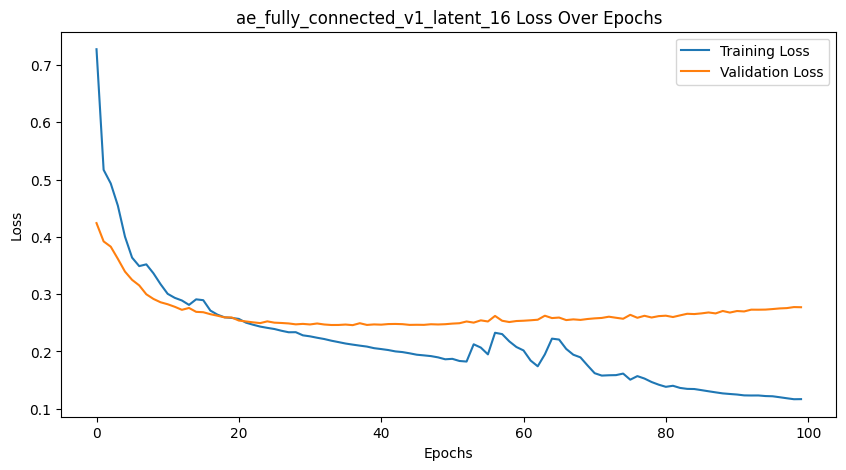

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Encoder model
encoder = keras.Model(inputs=inputs, outputs=bottleneck)
encoded_data = encoder.predict(X_scaled)

ae_name = f'{model_name}_v0.keras'
save_path_ae = os.path.join(st.settings["DIR_DATA_OUT"], cs.name, ae_name)
autoencoder.save(save_path_ae)
print("saved : ", ae_name)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
saved :  ae_fully_connected_v1_latent_16_v0.keras


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


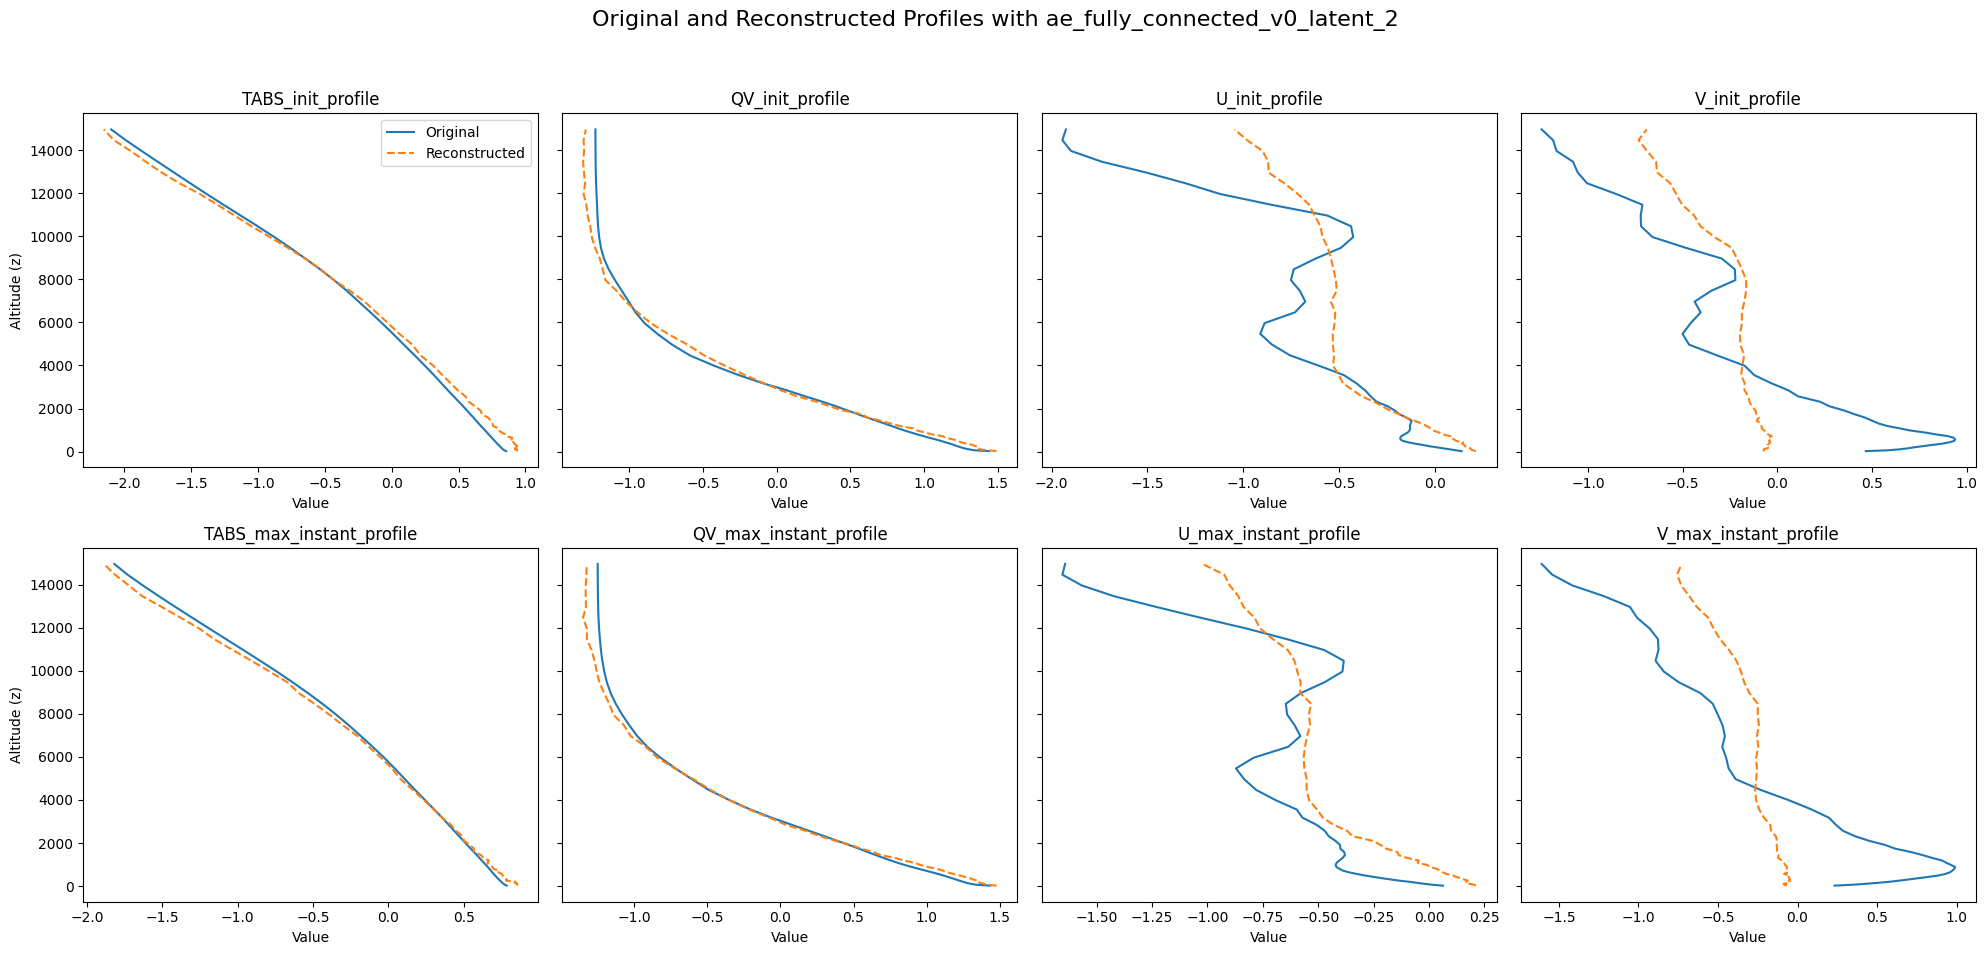

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming 'ds', 'X_scaled', and 'autoencoder' are already defined

# Variable names in the order they were concatenated
variables = [
    'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile'
]

indices = np.arange(num_samples)

# Perform train_test_split with indices to keep track
X_train, X_test, idx_train, idx_test = train_test_split(
    X_scaled, indices, test_size=0.2, random_state=42
)

# Reconstruct inputs using the trained autoencoder
reconstructed_data = autoencoder.predict(X_test)

sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original and reconstructed data for the selected sample
original_sample = X_test[sample_index]           # Shape: (num_levels, num_features)
reconstructed_sample = reconstructed_data[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values  # Vertical levels

# Extract the profiles for each variable
original_profiles = {}
reconstructed_profiles = {}

for i, var in enumerate(variables):
    original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
    reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)

# Plot profiles in subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i // 4, i % 4]
    # Plot original and reconstructed profiles
    ax.plot(original_profiles[var], z_levels, label='Original')
    ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
    ax.set_title(var)
    ax.set_xlabel('Value')
    if i % 4 == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Big model 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Define the latent space size and input dimensions
latent_space_size = 32
num_levels = 52  # Replace with your actual value
num_features = 8  # Replace with your actual value
input_shape = (num_levels, num_features)
inputs = layers.Input(shape=input_shape)

# Conv1D Encoder
def conv1d_encoder(inputs):
    x = layers.Conv1D(512, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Attention()([x, x])
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    bottleneck = layers.Dense(latent_space_size, activation='relu')(x)
    return bottleneck

# Conv1D Decoder
def conv1d_decoder(latent):
    x = layers.Dense(64, activation='relu')(latent)
    x = layers.Dense(num_levels * num_features, activation='relu')(x)
    x = layers.Reshape((num_levels, num_features))(x)
    x = layers.Conv1DTranspose(512, kernel_size=3, activation='relu', padding='same')(x)
    output = layers.Conv1DTranspose(num_features, kernel_size=3, activation='linear', padding='same')(x)
    return output

# LSTM Encoder
def lstm_encoder(inputs):
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.LSTM(num_features)(x)
    bottleneck = layers.Dense(latent_space_size, activation='relu')(x)
    return bottleneck

# LSTM Decoder
def lstm_decoder(latent):
    x = layers.RepeatVector(num_levels)(latent)
    x = layers.LSTM(num_features, return_sequences=True)(x)
    x = layers.LSTM(64, return_sequences=True)(x)
    output = layers.TimeDistributed(layers.Dense(num_features, activation='linear'))(x)
    return output

# Fully Connected Encoder
def fc_encoder(inputs):
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    bottleneck = layers.Dense(latent_space_size, activation='relu')(x)
    return bottleneck

# Fully Connected Decoder
def fc_decoder(latent):
    x = layers.Dense(64, activation='relu')(latent)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(num_levels * num_features, activation='linear')(x)
    output = layers.Reshape((num_levels, num_features))(x)
    return output

# Get latent representations from each encoder
latent_conv1d = conv1d_encoder(inputs)
latent_lstm = lstm_encoder(inputs)
latent_fc = fc_encoder(inputs)

# Get outputs from each decoder
output_conv1d = conv1d_decoder(latent_conv1d)
output_lstm = lstm_decoder(latent_lstm)
output_fc = fc_decoder(latent_fc)

# Stack the outputs along a new axis to prepare for attention
outputs = layers.Lambda(lambda x: K.stack(x, axis=2))([output_conv1d, output_lstm, output_fc])
# outputs shape: (batch_size, num_levels, 3, num_features)

# Reshape outputs for attention mechanism (no need to compute batch_size)
outputs_reshaped = layers.Reshape((num_levels * 3, num_features))(outputs)
# outputs_reshaped shape: (batch_size, num_levels * 3, num_features)

# Compute attention scores
attention_scores = layers.Dense(1, activation='tanh')(outputs_reshaped)
# attention_scores shape: (batch_size, num_levels * 3, 1)

# Apply softmax over the 'time' dimension
attention_weights = layers.Softmax(axis=1)(attention_scores)
# attention_weights shape: (batch_size, num_levels * 3, 1)

# Multiply outputs by attention weights
weighted_outputs = layers.Multiply()([outputs_reshaped, attention_weights])
# weighted_outputs shape: (batch_size, num_levels * 3, num_features)

# Sum over the 'time' dimension to get the context vector
context_vector = layers.Lambda(lambda x: K.sum(x, axis=1))(weighted_outputs)
# context_vector shape: (batch_size, num_features)

# Optionally, you can expand the context_vector to match the original input shape
reconstructed_output = layers.Dense(num_levels * num_features, activation='linear')(context_vector)
reconstructed_output = layers.Reshape((num_levels, num_features))(reconstructed_output)

# Define the combined autoencoder model
autoencoder = models.Model(inputs, reconstructed_output, name='combined_autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

# Display the model summary
autoencoder.summary()


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming 'ds', 'X_scaled', and 'autoencoder' are already defined

# Variable names in the order they were concatenated
variables = [
    'TABS_init_profile', 'QV_init_profile', 'U_init_profile', 'V_init_profile',
    'TABS_max_instant_profile', 'QV_max_instant_profile', 'U_max_instant_profile', 'V_max_instant_profile'
]

indices = np.arange(num_samples)

# Perform train_test_split with indices to keep track
X_train, X_test, idx_train, idx_test = train_test_split(
    X_scaled, indices, test_size=0.2, random_state=42
)

# Reconstruct inputs using the trained autoencoder
reconstructed_data = autoencoder.predict(X_test)

sample_index = np.random.choice(range(X_test.shape[0]))
ds_index = idx_test[sample_index]  # Index in the original dataset

# Extract the original and reconstructed data for the selected sample
original_sample = X_test[sample_index]           # Shape: (num_levels, num_features)
reconstructed_sample = reconstructed_data[sample_index]  # Shape: (num_levels, num_features)

z_levels = ds['z'].values  # Vertical levels

# Extract the profiles for each variable
original_profiles = {}
reconstructed_profiles = {}

for i, var in enumerate(variables):
    original_profiles[var] = original_sample[:, i]        # Shape: (num_levels,)
    reconstructed_profiles[var] = reconstructed_sample[:, i]  # Shape: (num_levels,)

# Plot profiles in subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
fig.suptitle('Original and Reconstructed Profiles with '+f"{model_name}", fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i // 4, i % 4]
    # Plot original and reconstructed profiles
    ax.plot(original_profiles[var], z_levels, label='Original')
    ax.plot(reconstructed_profiles[var], z_levels, label='Reconstructed', linestyle='--')
    ax.set_title(var)
    ax.set_xlabel('Value')
    if i % 4 == 0:
        ax.set_ylabel('Altitude (z)')
    ax.invert_yaxis()  # Invert y-axis if your altitude increases with decreasing index
    if i == 0:
        ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()